This project is to get aquainted with the tensorflow package. I will construct a neural network to identify handwritten numbers from the MNIST dataset. We begin by preparing the data as an array of values between $0$ and $1$ indicating the darkness of each pixel in the image.

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist

#Prepare the data into 1D arrays with values between 0 and 1.
num_class = 10
num_features = 784
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
x_train, x_test = x_train / 255., x_test / 255.


We will define a function that will plot the inputted sample with Matplotlib.

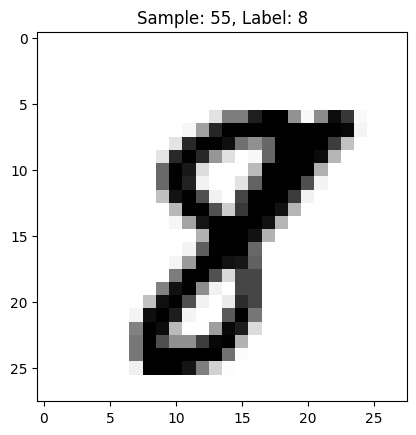

In [19]:
%matplotlib inline

import matplotlib.pyplot as plt

def displaySample(id):
    label = y_train[id]

    img = x_train[id].reshape([28,28])
    plt.title('Sample: '+ str(id) +', Label: ' + str(label))
    plt.imshow(img,cmap='gray_r')
    plt.show()

displaySample(55)


Define the training parameters and number of neurons. I have found that around $50$ to $100$ neurons provide the best results more than this results in an overfitting and lowers our accuracy. We also shuffle and batch the data for training.

In [51]:
# Training parameters.
learning_rate = 0.001
training_steps = 5000
batch_size = 250
display_step = 250

# Network parameters.
n_hidden = 50 #Number of neurons.

# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(60000).batch(batch_size).prefetch(1)

Here we define our weights and biases for each layer in the network.

In [52]:
# Store layers weight & bias

# A random value generator to initialize weights initially
random_normal = tf.initializers.RandomNormal()

weights = {
    'h': tf.Variable(random_normal([num_features, n_hidden])),
    'out': tf.Variable(random_normal([n_hidden, num_class]))
}
biases = {
    'b': tf.Variable(tf.zeros([n_hidden])),
    'out': tf.Variable(tf.zeros([num_class]))
}

We create the model with our weights and biases adding an activation function to the hidden layer. Since we are classifying the image we use a softmax to determine which classification the model has chosen.

In [59]:
# Create model.
def neural_net(inputData):
    # Hidden fully connected layer with 50 neurons.
    hidden_layer = tf.add(tf.matmul(inputData, weights['h']), biases['b'])
    # Apply sigmoid to hidden_layer output for non-linearity.
    hidden_layer = tf.nn.sigmoid(hidden_layer)
    
    # Output fully connected layer with a neuron for each class.
    out_layer = tf.matmul(hidden_layer, weights['out']) + biases['out']
    # Apply softmax to normalize the logits to a probability distribution.
    return tf.nn.softmax(out_layer)

Calculate the cross entropy to determine the performance of the weights.

In [54]:
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_class)
    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    # Compute cross-entropy.
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

Perform gradient descent to find better weights and biases. 

In [55]:
optimizer = tf.keras.optimizers.SGD(learning_rate)

def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        pred = neural_net(x)
        loss = cross_entropy(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = list(weights.values()) + list(biases.values())

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [56]:
# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

We now run the neural network, viewing the accuracy every 250 epochs.

In [60]:
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("Training epoch: %i, Loss: %f, Accuracy: %f" % (step, loss, acc))

Training epoch: 250, Loss: 40.099773, Accuracy: 0.944000
Training epoch: 500, Loss: 36.038246, Accuracy: 0.956000
Training epoch: 750, Loss: 28.773365, Accuracy: 0.976000
Training epoch: 1000, Loss: 38.109707, Accuracy: 0.952000
Training epoch: 1250, Loss: 51.311737, Accuracy: 0.940000
Training epoch: 1500, Loss: 31.361286, Accuracy: 0.944000
Training epoch: 1750, Loss: 33.010628, Accuracy: 0.952000
Training epoch: 2000, Loss: 34.820015, Accuracy: 0.960000
Training epoch: 2250, Loss: 27.299614, Accuracy: 0.968000
Training epoch: 2500, Loss: 29.685347, Accuracy: 0.968000
Training epoch: 2750, Loss: 34.171379, Accuracy: 0.960000
Training epoch: 3000, Loss: 38.150116, Accuracy: 0.960000
Training epoch: 3250, Loss: 34.499905, Accuracy: 0.976000
Training epoch: 3500, Loss: 21.355600, Accuracy: 0.980000
Training epoch: 3750, Loss: 25.926882, Accuracy: 0.972000
Training epoch: 4000, Loss: 27.292606, Accuracy: 0.968000
Training epoch: 4250, Loss: 24.740082, Accuracy: 0.972000
Training epoch: 4

Let's look at the accuracy on the test data to see its performance on data it has not seen before.

In [61]:
# Test model on validation set.
pred = neural_net(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.964800


A $96\%$ accuracy is not bad! We may come back to this with convolution neural networks to see how they compare.